# Neural Image Compression # 

Using local Data to test functionality with a few WSIs


## Imports ##

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
from tqdm import tqdm
import os, shutil
from os.path import join, dirname, exists
import keras
from gradcam_wsi import gradcam_on_dataset
from preprocessing import data_to_csv
import getpass  # get user name

## Data ##

To demonstrate the functionality of NIC, we will need a set of whole-slide images (WSIs) with their respective slide-level labels. In this case, we will use the WSIs that can be found using the following pattern:

These data was already reorganized, it is, all the tiff files are contained in one folder for each class. 

These are a small version of the TCGA dataset:

`E:\pathology-weakly-supervised-lung-cancer-growth-pattern-prediction\data\tcga_luad\images_diagnostic`

`E:\pathology-weakly-supervised-lung-cancer-growth-pattern-prediction\data\tcga_lusc\images_diagnostic`

The data we are going to use is only the **diagnostic** data and no the **tissue** data. The mask are already given, but we will have to implementa script to create this masks that filter out the background.


Because there is no slide-level csv file, we have to create one, this will be created after once we get the featurized wsi. FIle should be located at  from:

`E:\pathology-weakly-supervised-lung-cancer-growth-pattern-prediction\data\slide_original_list_tcga.csv`


In [4]:
username = getpass.getuser()
username = 'Chensey'
print(f'Working directory: {username}')

if  username == 'Gabriel Raya':
    # project and data directories
    root_dir=  r'E:\pathology-weakly-supervised-lung-cancer-growth-pattern-prediction'
    data_dir = r'E:\pathology-weakly-supervised-lung-cancer-growth-pattern-prediction\data'

    # wsi directories
    dir_luad_wsi = os.path.join(data_dir, 'tcga_luad', 'wsi_diagnostic_tif')
    dir_lusc_wsi = os.path.join(data_dir, 'tcga_lusc', 'wsi_diagnostic_tif')
    dir_luad_wsi_mask = os.path.join(data_dir, 'tcga_luad', 'tissue_masks_diagnostic')
    dir_lusc_wsi_mask = os.path.join(data_dir, 'tcga_lusc', 'tissue_masks_diagnostic')
    
    # Set paths
    model_path = './neural-image-compression-private/models/encoders_patches_pathology/encoder_bigan.h5'
    csv_train = os.path.join(data_dir, 'train_slide_list_tcga.csv')
    csv_val = os.path.join(data_dir, 'validation_slide_list_tcga.csv')
    csv_test = os.path.join(data_dir, 'test_slide_list_tcga.csv')
    
else:
    # Data on chensey
    root_dir=  r'Z:\projects\pathology-weakly-supervised-lung-cancer-growth-pattern-prediction'
    data_dir = r'Z:\archives\lung'
    
    # wsi directories
    dir_luad_wsi = join(data_dir, 'TCGA_LUAD', 'wsi_diagnostic_tif')
    dir_lusc_wsi = join(data_dir, 'TCGA_LUSC', 'wsi_diagnostic_tif')
    dir_luad_wsi_mask = os.path.join(data_dir, 'TCGA_LUAD', 'tissue_masks_diagnostic')
    dir_lusc_wsi_mask = os.path.join(data_dir, 'TCGA_LUSC', 'tissue_masks_diagnostic')
    
    # Set paths
    model_path = './neural-image-compression-private/models/encoders_patches_pathology/encoder_bigan.h5'
    csv_train = os.path.join(root_dir, 'data', 'train_slide_list_tcga.csv')
    csv_val = os.path.join(root_dir, 'data', 'validation_slide_list_tcga.csv')
    csv_test = os.path.join(root_dir, 'data', 'test_slide_list_tcga.csv')
    
# compressed image directories
vectorized_luad_dir = join(root_dir, 'results', 'tcga_luad', 'vectorized')
vectorized_lusc_dir = join(root_dir, 'results', 'tcga_lusc', 'vectorized')
featurized_luad_dir = join(root_dir, 'results', 'tcga_luad', 'featurized')
featurized_lusc_dir = join(root_dir, 'results', 'tcga_lusc', 'featurized')
    
# results directory 
result_dir = join(root_dir, 'results', 'models', 'baseline_local')  # store the results from trained model
gradcam_dir = join(result_dir, 'gradcam')        # store gradcam results

# csv paths
csv_path_wsi =  os.path.join(root_dir,'data/slide_original_list_tcga.csv')

cache_dir = None  # used to store local copies of files during I/O operations (useful in cluster

Working directory: Chensey


## 0. Preprocessing

We need to create a csv file to point out the data.

In [9]:
from preprocessing import create_csv

print('Creating main csv data files from original data...')
create_csv(dir_luad_wsi, dir_lusc_wsi, csv_train, '.tif')

# read files to check shapes
df = pd.read_csv(csv_train)
print(f'Files were read with shapes: {df.shape}')
print(df['label'].value_counts())
df.head()

Creating main csv data files from original data...


100%|██████████| 506/506 [00:00<00:00, 72298.34it/s]


Csv file sucessfully exported!
Files were read with shapes: (1037, 2)
1    531
0    506
Name: label, dtype: int64


,slide_id,label
0,TCGA-05-4244-01Z-00-DX1,1
1,TCGA-05-4245-01Z-00-DX1,1
2,TCGA-05-4249-01Z-00-DX1,1
3,TCGA-05-4250-01Z-00-DX1,1
4,TCGA-05-4382-01Z-00-DX1,1


## 1. Encoder network ##

To perform NIC, we will need an encoder network to transform small image patches into embedding vectors. According to the paper, BiGAN produces the best unsupervised encoder and it is the one we will train here.

Alternatively, a collection of pretrained encoders (the one used in the NIC paper) can be found in 

`./models/encoders_patches_pathology/*.h5`

Remember that these pretrained encoders accept 128x128x3 patches taken at 0.5 um/px resolution (often level 1), except for the BiGAN model that takes 64x64x3 at 1 um/px (often level 2).



In order to train the BiGAN model, we will first extract patches from the slides in the `encoder` partition. We will sample 10K patches per slide, producing ~260K patches in total. We select 96x96 patches to perform crop augmentation during training later.

In [4]:
# # # Dont run this we, will train later the encoder but not now. 

# from nic.extract_patches import wsi_to_patches

# #patches_npy_path = join(root_dir, 'results', 'patches', 'training.npy')

# slide_dir= join(dir_luad_wsi, 'TCGA-05-4244-01Z-00-DX1.tif')


# # Extracts patches from whole-slide images and store them in a numpy array file
# patches_npy_path = wsi_to_patches(
#                         image_path=slide_dir,
#                         image_level=2,
#                         patch_size=96,
#                         n_patches=10000
#                     )

In [5]:
# plt.imshow(patches_npy_path[10])

In [6]:
# patches_npy_path[0].shape

Once we have extracted the patches, we can proceed to train the BiGAN model. We will use the hyper-parameters described in the NIC paper. 

In [7]:
# from source.train_bigan_model import BiganModel

# model_bigan_dir = join(root_dir, 'results', 'encoders', 'bigan', 'rotterdam1_96_noaug', '0.0001')

# # Trains BiGAN
# bigan = BiganModel(
#     latent_dim=128,
#     n_filters=128,
#     lr=0.0001,
#     patch_size=64,
# )
# bigan.train(
#     x_path=patches_npy_path,
#     output_dir=model_bigan_dir,
#     epochs=400000,
#     batch_size=64,
#     sample_interval=1000,
#     save_models_on_epoch=True
# )

Beware that training this model is highly unstable, thus it can fail or collapse with ease. If this happens, restart the training. Selecting a checkpoint model is a manual procedure: check the generated images and loss values and avoid abnormal results. 

## 2. Compress images ##

Once we have a trained encoder, we can proceed with the WSI compression. I recommend running several `IDLE` instances of the following code in the cluster to speed up the lenghty process.

Before the actual compression, we need to vectorize the WSIs. This process extracts all non-background patches from the slide and store them in numpy array format for quick access. In this case, we will read 64x64 patches at 1 um/px resolution (level 2).

In [8]:
# Vectorize LUAD WSIs
from vectorize_wsi import vectorize_images

vectorize_images(
    input_dir=dir_luad_wsi,
    mask_dir=dir_luad_wsi_mask, 
    output_dir=vectorized_luad_dir, 
    cache_dir=cache_dir, 
    image_level=2, 
    patch_size=128
    )

Already existing file TCGA-05-4244-01Z-00-DX1 - 9 images left
Already existing file TCGA-05-4245-01Z-00-DX1 - 8 images left
Already existing file TCGA-05-4249-01Z-00-DX1 - 7 images left
Already existing file TCGA-05-4250-01Z-00-DX1 - 6 images left
Already existing file TCGA-05-4382-01Z-00-DX1 - 5 images left
Already existing file TCGA-05-4395-01Z-00-DX1 - 4 images left
Already existing file TCGA-05-4396-01Z-00-DX1 - 3 images left
Already existing file TCGA-05-4397-01Z-00-DX1 - 2 images left
Already existing file TCGA-05-4398-01Z-00-DX1 - 1 images left
Already existing file TCGA-4B-A93V-01Z-00-DX1 - 0 images left
Finish Processing All images!


In [9]:
# Vectorize LUSC WSIs

vectorize_images(
    input_dir=dir_lusc_wsi,
    mask_dir=dir_lusc_wsi_mask, 
    output_dir=vectorized_lusc_dir, 
    cache_dir=cache_dir, 
    image_level=2, 
    patch_size=128
    )

Already existing file TCGA-33-4538-01Z-00-DX3 - 9 images left
Already existing file TCGA-52-7812-01Z-00-DX1 - 8 images left
Already existing file TCGA-60-2721-01Z-00-DX1 - 7 images left
Already existing file TCGA-77-8007-01Z-00-DX1 - 6 images left
Already existing file TCGA-77-8009-01Z-00-DX1 - 5 images left
Already existing file TCGA-77-8139-01Z-00-DX1 - 4 images left
Already existing file TCGA-77-8143-01Z-00-DX1 - 3 images left
Already existing file TCGA-77-A5G1-01Z-00-DX1 - 2 images left
Already existing file TCGA-NK-A5CR-01Z-00-DX1 - 1 images left
Already existing file TCGA-NK-A5D1-01Z-00-DX1 - 0 images left
Finish Processing All images!


Now we can compress the WSIs. Each WSI (vectorized file) will be processed 8 times due to WSI-level augmentation (rotation and flip). We will use an existing pretrained encoder from the NIC paper.

In [10]:
# Featurize images
from featurize_wsi import featurize_images

# Featurize LUAD data
featurize_images(
    input_dir=vectorized_luad_dir,
    model_path=model_path, 
    output_dir=featurized_luad_dir, 
    batch_size=32
    )

Instructions for updating:
Colocations handled automatically by placer.
Already existing file TCGA-05-4244-01Z-00-DX1_{item} - 9 images left
Already existing file TCGA-05-4245-01Z-00-DX1_{item} - 8 images left
Already existing file TCGA-05-4249-01Z-00-DX1_{item} - 7 images left
Already existing file TCGA-05-4250-01Z-00-DX1_{item} - 6 images left
Already existing file TCGA-05-4382-01Z-00-DX1_{item} - 5 images left
Already existing file TCGA-05-4395-01Z-00-DX1_{item} - 4 images left
Already existing file TCGA-05-4396-01Z-00-DX1_{item} - 3 images left
Already existing file TCGA-05-4397-01Z-00-DX1_{item} - 2 images left
Already existing file TCGA-05-4398-01Z-00-DX1_{item} - 1 images left
Already existing file TCGA-4B-A93V-01Z-00-DX1_{item} - 0 images left
Finish Processing All images!


In [11]:
# Featurize LUSC data
featurize_images(
    input_dir=vectorized_lusc_dir,
    model_path=model_path, 
    output_dir=featurized_lusc_dir, 
    batch_size=32
    )

Already existing file TCGA-33-4538-01Z-00-DX3_{item} - 9 images left
Already existing file TCGA-52-7812-01Z-00-DX1_{item} - 8 images left
Already existing file TCGA-60-2721-01Z-00-DX1_{item} - 7 images left
Already existing file TCGA-77-8007-01Z-00-DX1_{item} - 6 images left
Already existing file TCGA-77-8009-01Z-00-DX1_{item} - 5 images left
Already existing file TCGA-77-8139-01Z-00-DX1_{item} - 4 images left
Already existing file TCGA-77-8143-01Z-00-DX1_{item} - 3 images left
Already existing file TCGA-77-A5G1-01Z-00-DX1_{item} - 2 images left
Already existing file TCGA-NK-A5CR-01Z-00-DX1_{item} - 1 images left
Already existing file TCGA-NK-A5D1-01Z-00-DX1_{item} - 0 images left
Finish Processing All images!


## 3. Train CNN on compressed images ##

Once we have compressed the WSIs, we can proceed with the CNN classifier. In this example, we will train a classifier targeting the binary label `HGP_SL` found in the CSV file. We will be training 4 models using cross-validation: in each fold, we will use 2 data partitions for training, 1 for validation and 1 for testing. At the end of model training, we perform inference on the test set, compute metrics, and run GradCAM on the images.



In [12]:
from model_training import train_wsi_classifier, eval_model, compute_metrics
from utils import check_file_exists

def train_model(featurized_dir, csv_path, fold_n, output_dir, cache_dir, batch_size=16, epochs=32,
                images_dir=None, vectorized_dir=None, lr=1e-2, patience=4, delete_folder=False,
                occlusion_augmentation=False, elastic_augmentation=False, shuffle_augmentation=None):
    """
    Trains a CNN using compressed whole-slide images.

    :param featurized_dir: folder containing the compressed (featurized) images.
    :param csv_path: list of slides with labels.
    :param fold_n: fold determining which data partitions to use for training, validation and testing.
    :param output_dir: destination folder to store results.
    :param cache_dir: folder to store compressed images temporarily for fast access.
    :param batch_size: number of samples to train with in one-go.
    :return: nothing.
    """
    
    # Delete folder and subfolders if exists
    if delete_folder: 
        if exists(result_dir):  shutil.rmtree(result_dir)
            
    # Train CNN
    train_wsi_classifier(
        data_dir=featurized_dir,
        csv_path=csv_path,
        partitions=None,
        crop_size=400,
        output_dir=output_dir,
        output_units=2,
        cache_dir=cache_dir,
        n_epochs=epochs,
        batch_size=batch_size,
        lr=lr,
        code_size=128,
        workers=1,
        train_step_multiplier=1,
        val_step_multiplier=0.5,
        keep_data_training=1,
        keep_data_validation=1,
        patience=patience,
        occlusion_augmentation=occlusion_augmentation,
        elastic_augmentation=elastic_augmentation,
        shuffle_augmentation=shuffle_augmentation
    )  

    # Evaluate CNN 
    
    # Get compressed wsi directories with csv test file
    data_config = featurized_dir
    data_config['csv_path'] = csv_path['csv_test']
    
    eval_model(
        model_path=join(output_dir, 'checkpoint.h5'),
        data_config=data_config,
        crop_size=400,
        output_path=join(output_dir, 'eval', 'preds.csv'),
        cache_dir=None,
        batch_size=batch_size,
        keep_data=1
    )

    # Metrics
    try:
        compute_metrics(
            input_path=join(output_dir, 'eval', 'preds.csv'),
            output_dir=join(output_dir, 'eval')
        )
    except Exception as e:
        print('Failed to compute metrics. Exception: {e}'.format(e=e), flush=True)

#     # Apply GradCAM analysis to CNN
#     gradcam_on_dataset(
#         featurized_dir=featurized_dir,
#         csv_path=csv_path,
#         model_path=join(output_dir, 'checkpoint.h5'),
#         partitions=folds[fold_n]['test'],
#         layer_name='separable_conv2d_1',
#         output_unit=1,
#         custom_objects=None,
#         cache_dir=cache_dir,
#         images_dir=images_dir,
#         vectorized_dir=vectorized_dir
#     )

In [13]:
# Train CNN

#selected_fold = 0

featurized_dir = {'data_dir_luad': featurized_luad_dir, 'data_dir_lusc': featurized_lusc_dir}
csv_path = {'csv_train': csv_train, 'csv_val': csv_val, 'csv_test': csv_test}

train_model(
    featurized_dir=featurized_dir,
    csv_path=csv_path,
    fold_n=0, 
    output_dir=result_dir,
    cache_dir=None,
    batch_size =4,
    epochs=2,
    delete_folder=True,
    occlusion_augmentation=False,
    lr=1e-2,
    patience=4,
    elastic_augmentation=False,
    images_dir=None,  # required for GradCAM
    vectorized_dir=None,  # required for GradCAM
    shuffle_augmentation=None
)

Loading training set ...
FeaturizedWsiGenerator data config: {'data_dir_luad': 'E:\\pathology-weakly-supervised-lung-cancer-growth-pattern-prediction\\results\\tcga_luad\\featurized', 'data_dir_lusc': 'E:\\pathology-weakly-supervised-lung-cancer-growth-pattern-prediction\\results\\tcga_lusc\\featurized', 'csv_path': 'E:\\pathology-weakly-supervised-lung-cancer-growth-pattern-prediction\\data\\train_slide_list_tcga.csv'}
FeaturizedWsiGenerator using 11 samples and 3 batches, distributed in 4 positive and 7 negative samples.
Loading validation set ...
FeaturizedWsiSequence data config: {'data_dir_luad': 'E:\\pathology-weakly-supervised-lung-cancer-growth-pattern-prediction\\results\\tcga_luad\\featurized', 'data_dir_lusc': 'E:\\pathology-weakly-supervised-lung-cancer-growth-pattern-prediction\\results\\tcga_lusc\\featurized', 'csv_path': 'E:\\pathology-weakly-supervised-lung-cancer-growth-pattern-prediction\\data\\validation_slide_list_tcga.csv'}
FeaturizedWsiSequence using 5 samples and

## Aplying GradCam

Here we get the folder separetely

In [14]:
print('GradCam will be apply to this dataset!')
csv_path_luad_feat = join(data_dir, 'slide_list_featurized_luad.csv')
data_to_csv(featurized_luad_dir, csv_path_luad_feat)
pd.read_csv(csv_path_luad_feat)

GradCam will be apply to this dataset!


100%|██████████| 30/30 [00:00<00:00, 7499.20it/s]


Csv file sucessfully exported!


,slide_id,label
0,TCGA-05-4244-01Z-00-DX1,1
1,TCGA-05-4245-01Z-00-DX1,1
2,TCGA-05-4249-01Z-00-DX1,1
3,TCGA-05-4250-01Z-00-DX1,1
4,TCGA-05-4382-01Z-00-DX1,1
5,TCGA-05-4395-01Z-00-DX1,1
6,TCGA-05-4396-01Z-00-DX1,1
7,TCGA-05-4397-01Z-00-DX1,1
8,TCGA-05-4398-01Z-00-DX1,1
9,TCGA-4B-A93V-01Z-00-DX1,1


In [15]:
# for layer in model.layers:
#     print(layer.name)
# Apply GradCAM analysis to CNN on LUAD data

# Apply GradCam on layer 1
gradcam_on_dataset(
    data_dir=[featurized_luad_dir, featurized_lusc_dir],
    csv_path=csv_path_luad_feat,
    model_path=join(result_dir, 'checkpoint.h5'),
    partitions=0,
    layer_number=1,
    custom_objects=None,
    cache_dir=cache_dir,
    images_dir=dir_luad_wsi,
    vectorized_dir=vectorized_luad_dir,
    output_dir=gradcam_dir,
    predict_two_output = True
)

GradCAM in directory: E:\pathology-weakly-supervised-lung-cancer-growth-pattern-prediction\results\models\baseline_local\gradcam with content 0
Computing GradCAM on TCGA-05-4249-0 ... 1/10


D:\Users\Gabriel\Anaconda3\envs\tensorflow\lib\site-packages\scipy\ndimage\interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Computing GradCAM on TCGA-05-4397-0 ... 2/10
Computing GradCAM on TCGA-05-4382-0 ... 3/10
Computing GradCAM on TCGA-4B-A93V-0 ... 4/10
Computing GradCAM on TCGA-05-4398-0 ... 5/10
Computing GradCAM on TCGA-05-4245-0 ... 6/10
Computing GradCAM on TCGA-05-4244-0 ... 7/10
Computing GradCAM on TCGA-05-4395-0 ... 8/10
Computing GradCAM on TCGA-05-4396-0 ... 9/10
Computing GradCAM on TCGA-05-4250-0 ... 10/10


In [16]:
def plot_gradcam(gradcam_images):
    %matplotlib inline
    rows = 3; columns = 5;
    fig, axs = plt.subplots(rows,columns,figsize=(20,8))
    axs = axs.ravel()
    n_images = rows * columns

    for idx in range(n_images):
        img = plt.imread(gradcam_images[idx])
        if idx == 0: print(f'Images shape: {img.shape}')
        axs[idx].imshow(img)
        prefix = os.path.basename(gradcam_images[idx]).split('_')[0]
        subfix = os.path.basename(gradcam_images[idx]).split('_')[-1]
        axs[idx].set_title(prefix + '_' + subfix)
        axs[idx].set_xlabel(prefix + subfix)
        axs[idx].get_xaxis().set_visible(False)
        axs[idx].get_yaxis().set_visible(False)

Images shape: (400, 400, 4)


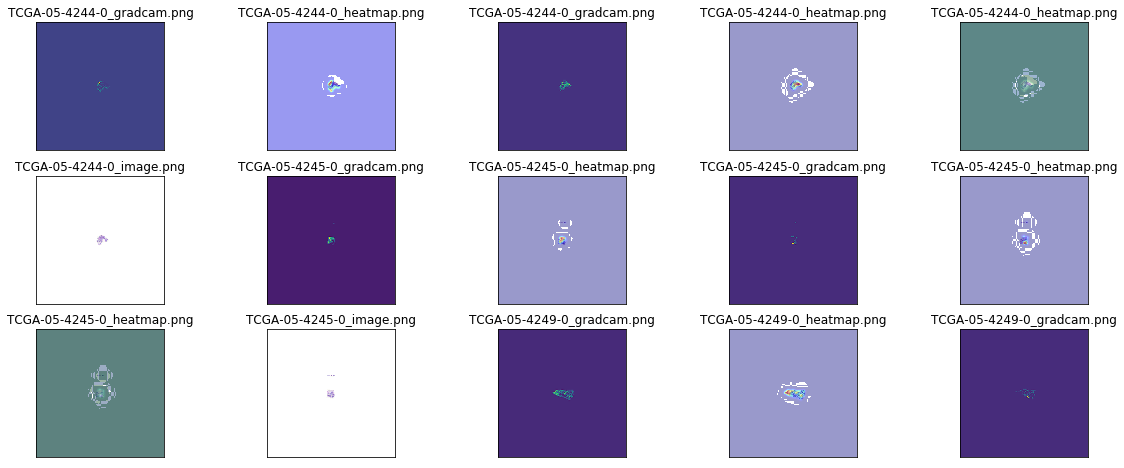

In [17]:
# Get gradcam images
gradcam_images = sorted([os.path.join(gradcam_dir, f) for f in os.listdir(gradcam_dir) if f.endswith('.png')])

# Plot images
plot_gradcam(gradcam_images)